<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/v1__gray_local_histo_aug_keras_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Library

In [16]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.5f}".format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

import os
from os import listdir
from os.path import isfile, join
import cv2
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
tf.__version__

'2.8.2'

In [17]:
# Visualization
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import skimage.morphology as morp
from skimage.filters import rank

TensoFlow Version:  2.8.2


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn"

In [5]:
import os
os.chdir(data_path)

In [6]:
data = []
labels = []

height = 32
width = 32
channels = 3
num_classes = 43

In [ ]:
# for i in range(num_classes) :
#     path = f'./data/Train/{i}/'
#     Class = os.listdir(path)
#     for a in Class:
#         image = cv2.imread(path + a)
#         image_from_array = Image.fromarray(image, 'RGB')
#         size_image = image_from_array.resize((height, width))
#         data.append(np.array(size_image))
#         labels.append(i)

# data = np.array(data)
# labels = np.array(labels)

# import pickle
# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","wb") as f:
#     pickle.dump(data, f)

# with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","wb") as f:
#     pickle.dump(labels, f)

In [ ]:
for a in Class:
    image = cv2.imread(path + a)
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))
    image = img_Contrast(image)
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

    data = np.array(data)
    labels = np.array(labels)

    import pickle
    with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","wb") as f:
        pickle.dump(data, f)

    with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","wb") as f:
        pickle.dump(labels, f)

In [35]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_data.pkl","rb") as f:
    data = pickle.load(f)

import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Kaggle/project_2_cnn/data/train_label.pkl","rb") as f:
    labels = pickle.load(f)

In [36]:
print(data.shape)
print(labels.shape)

(26010, 32, 32, 3)
(26010,)


### 데이터 로드

In [97]:
X = data
y = tf.one_hot(labels, num_classes).numpy()

In [98]:
print(X.shape)
print(y.shape)

(26010, 32, 32, 3)
(26010, 43)


### 탐색 분석

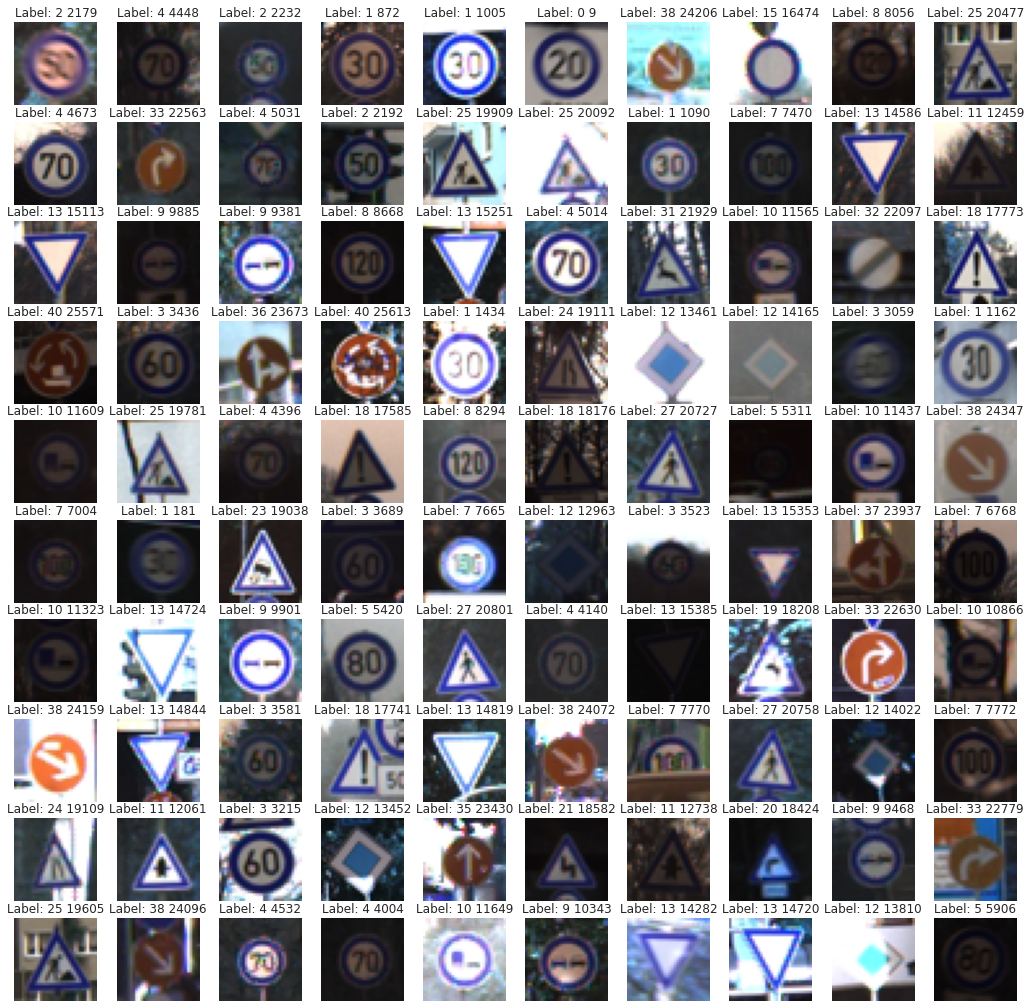

In [ ]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r]))+" "+str(r))

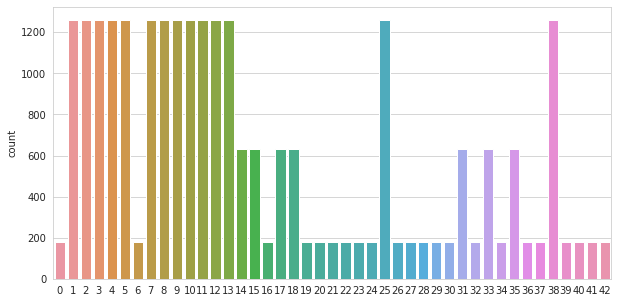

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(labels)

In [ ]:
uni_pattern = np.unique(labels, return_counts=True)
idxs = uni_pattern[0]
ratios = uni_pattern[1]/len(labels)

### Data Augmentation

```python

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )
```

In [99]:
X_origin = X.copy()

In [104]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    ret_data = np.zeros((n_training[0],  n_training[1],  n_training[2]))
    for i, img in enumerate(gray_images):
        ret_data[i] = img
    #     ret_data[i] = image_normalize(img)

    ret_data = ret_data[..., None]
    return ret_data

In [105]:
X = preprocess(X)
X.shape

(26010, 32, 32, 1)

In [ ]:
# def to_grayscale_then_rgb(image):
#     image = tf.image.rgb_to_grayscale(image)
#     image = tf.image.grayscale_to_rgb(image)
#     return np.array(image)

In [106]:
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.6, 0.9],
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
)

test_datagen  = ImageDataGenerator(
    rescale=1./255,
)

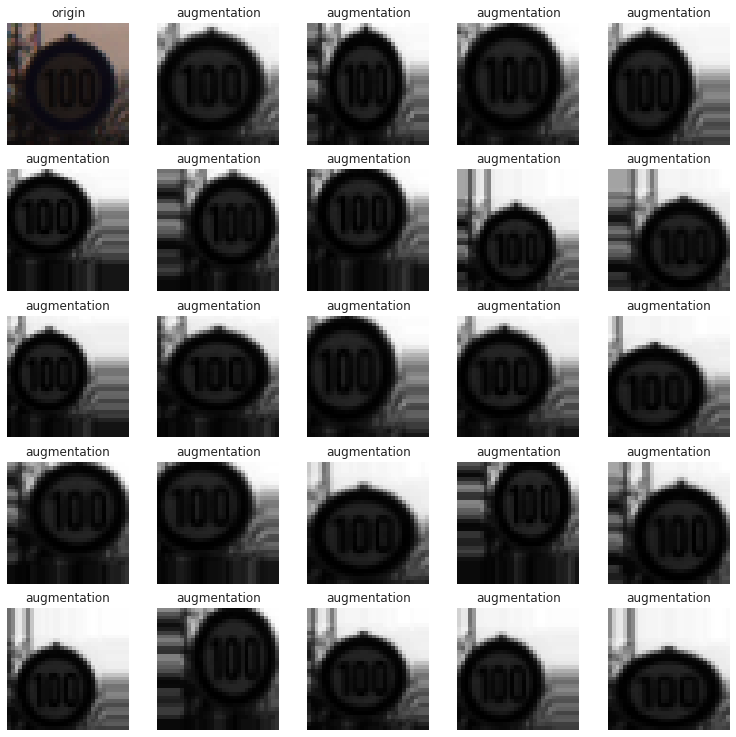

In [107]:
idx = 6768
input_img = X[idx]
input_label = y[idx]
input_img =  np.array([input_img]) 

generator = train_datagen.flow(input_img, batch_size=1)

f, axes = plt.subplots(5, 5, figsize=(13, 13))
ax_list = axes.flat
ax_list[0].imshow(X_origin[idx])
ax_list[0].axis('off')
ax_list[0].set_title("origin")

for i, img in enumerate(generator):
    ax_list[i+1].imshow(img[0].squeeze(axis=2),  cmap="gray")
    ax_list[i+1].axis('off')   
    ax_list[i+1].set_title("augmentation")
    if i > 22:
        break

### 전처리

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [119]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (20808, 32, 32, 1)
Test Shape : (5202, 32, 32, 1)


### 모델 생성

In [120]:
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size = 32
) 

validation_generator = test_datagen.flow(
        X_test, y_test,
        batch_size = 32
)


In [121]:
img_rows, img_cols = 32, 32
img_channels = 3
nb_classes = 43

In [122]:
img_channels = 1

In [123]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [124]:
x = resnet.output
x = GlobalAveragePooling2D()(x) ## flatten 대신
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [ ]:
# model.summary()

In [ ]:
# plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

### 모델 학습

In [125]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)
csv_logger = CSVLogger('train_log.csv', separator=',')

In [127]:
n_epochs = 50
history =  model.fit(
            train_generator, 
            batch_size = 32, epochs = n_epochs, verbose = 1, 
            validation_data=validation_generator, 
            callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
651/651 [==============================] - 27s 33ms/step - loss: 4.6075 - accuracy: 0.0838 - val_loss: 8.6921 - val_accuracy: 0.0744 - lr: 0.0010
Epoch 2/50
651/651 [==============================] - 23s 35ms/step - loss: 4.0017 - accuracy: 0.1301 - val_loss: 3.0170 - val_accuracy: 0.1524 - lr: 0.0010
Epoch 3/50
651/651 [==============================] - 19s 29ms/step - loss: 3.7868 - accuracy: 0.1719 - val_loss: 30.4025 - val_accuracy: 0.1353 - lr: 0.0010
Epoch 4/50
651/651 [==============================] - 19s 29ms/step - loss: 3.0964 - accuracy: 0.2962 - val_loss: 808.0372 - val_accuracy: 0.0977 - lr: 0.0010
Epoch 5/50
651/651 [==============================] - 23s 36ms/step - loss: 2.9891 - accuracy: 0.3162 - val_loss: 4.3601 - val_accuracy: 0.1617 - lr: 0.0010
Epoch 6/50
651/651 [==============================] - 19s 29ms/step - loss: 3.0377 - accuracy: 0.2756 - val_loss: 50.1811 - val_accuracy: 0.1276 - lr: 0.0010
Epoch 7/50
651/651 [==============================] - 

In [128]:
model_name = "model_resnet_augmentation_grayscale_local_histo.h5"

In [129]:
model.save(model_name)

### 모델 평가

In [130]:
from tensorflow import keras 
best_model = keras.models.load_model("best_model.h5")

In [135]:
loss, acc = model.evaluate(X_test/255.0, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

163/163 [==============================] - 2s 11ms/step - loss: 0.3257 - accuracy: 0.9102
Accuracy:  0.9102268218994141 
Loss    :  0.32572993636131287


In [136]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test/255.0)
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [137]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.98      0.94      0.96       255
           2       1.00      0.83      0.90       273
           3       0.89      0.91      0.90       255
           4       0.92      0.97      0.94       263
           5       0.70      0.99      0.82       249
           6       1.00      0.83      0.91        35
           7       1.00      0.60      0.75       231
           8       0.79      0.95      0.86       212
           9       1.00      0.92      0.96       236
          10       0.97      0.94      0.96       250
          11       0.96      0.96      0.96       247
          12       0.89      0.97      0.93       254
          13       0.99      0.98      0.99       254
          14       1.00      0.98      0.99       151
          15       0.89      1.00      0.94       118
          16       1.00      0.88      0.93        40
          17       1.00    

In [138]:
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(9)))

[[ 24   2   0   0   0   0   0   0   0]
 [  0 239   1   0  11   2   0   0   0]
 [  0   3 226   2   8  15   0   0   2]
 [  0   0   0 232   0  15   0   0   0]
 [  0   0   0   0 255   1   0   0   1]
 [  0   0   0   1   0 247   0   0   0]
 [  0   0   0   0   0   0  29   0   0]
 [  0   1   0   0   1  38   0 139  47]
 [  0   0   0   1   2   3   0   0 201]]


In [ ]:
# q = len(list(history.history['loss']))
# plt.figure(figsize=(12, 6))
# sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
# sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
# plt.xlabel('#epochs')
# plt.ylabel('Training')
# plt.legend();

### 모델 테스트

In [ ]:
from tensorflow import keras 
model = keras.models.load_model(model_name)

### 테스트 데이터 예측

In [ ]:
# test_data = []
# file_name = []
# path = f'./data/Test/'
# Class = os.listdir(path)
# for a in Class:
#     image = cv2.imread(path + a)
#     image_from_array = Image.fromarray(image, 'RGB')
#     size_image = image_from_array.resize((height, width))
#     test_data.append(np.array(size_image))
#     file_name.append(a)

# test_data = np.array(test_data)
# file_name = np.array(file_name)

In [ ]:
# import pickle 

# with open('./data/test_data.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

# with open('./data/file_name.pkl', 'wb') as f:
#     pickle.dump(file_name, f)

In [145]:
with open('./data/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('./data/file_name.pkl', 'rb') as f:
    file_name = pickle.load(f)

In [146]:
test_data_origin = test_data.copy()

In [147]:
test_data = preprocess(test_data)
test_data.shape

(8670, 32, 32, 1)

In [148]:
y_test = model.predict(test_data/255.0)
y_test = tf.argmax(y_test, axis=1).numpy()

In [143]:
def show_label_image(data, label, file_name, category):
    fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize=(18, 18))
    img_filter = np.argwhere(label==category).reshape(-1)
    img = data[img_filter]
    name = file_name[img_filter]
    index = np.random.choice(list(range(len(img))), 100)
    for i, ax in enumerate(axes.flat):
        r = index[i]
        ax.imshow(img[r])
        ax.set_title(name[r], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show() 

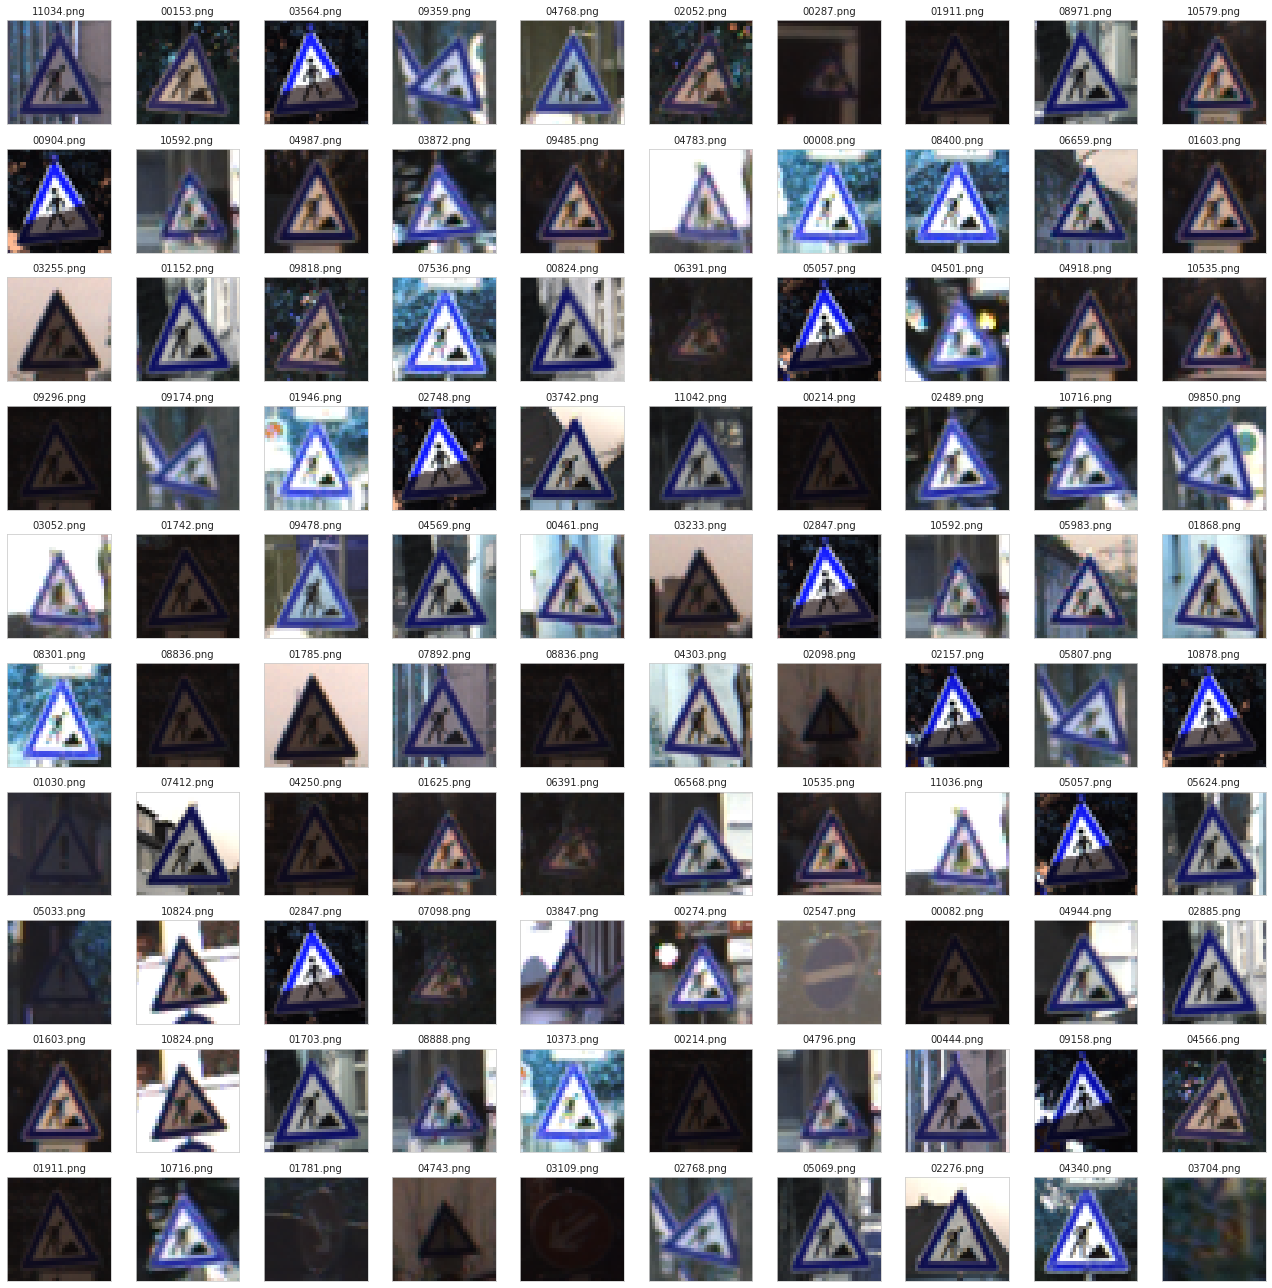

In [149]:
show_label_image(test_data_origin, y_test, file_name, 25)

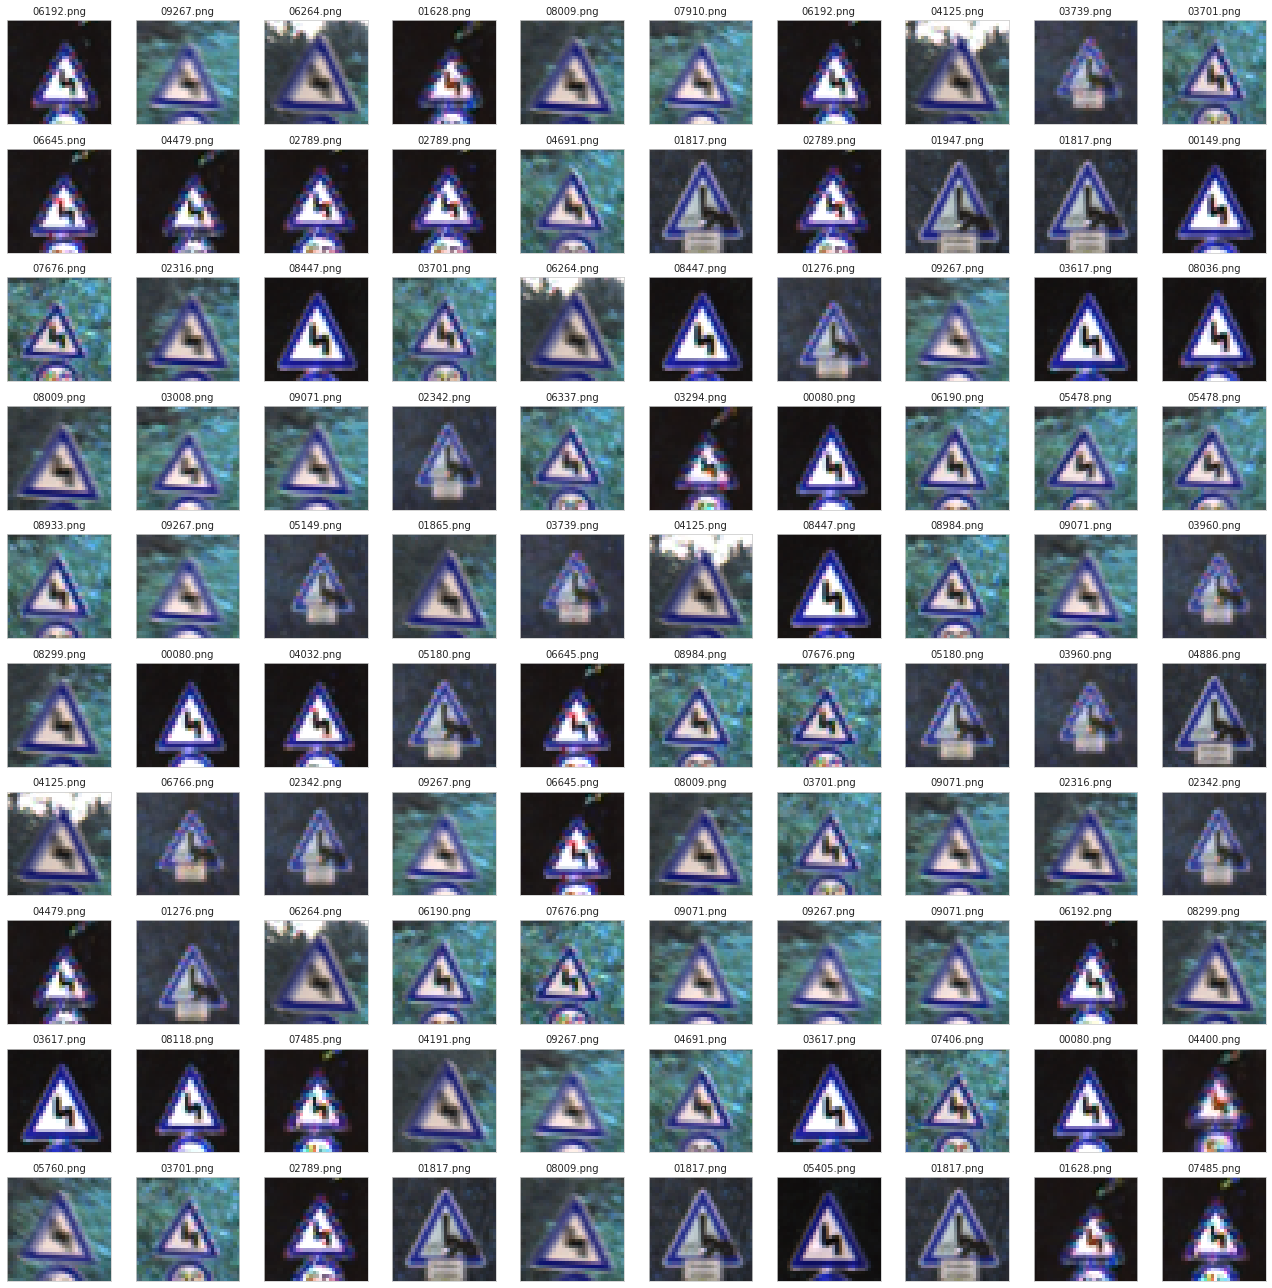

In [151]:
show_label_image(test_data_origin, y_test, file_name, 21)

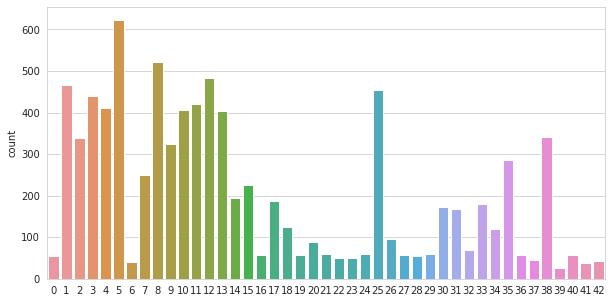

In [150]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y_test)

In [152]:
csv_data = pd.DataFrame(np.concatenate((file_name.reshape(-1, 1), y_test.reshape(-1,1)), axis=1))

In [153]:
csv_data = csv_data.sort_values(by=[0])
csv_data.head()

,0,1
279,00000.png,16
8119,00001.png,1
3628,00002.png,38
1565,00003.png,40
5360,00004.png,11


In [154]:
csv_data.to_csv("predicted_output.csv", header=False, index=False)

### 주석